# Load in basic imports

In [1]:
from pypeit.core.telluric import general_spec_reader
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import scipy

# Define userful normalization and rotational broadening functions

### Note: If using the functions below for rotational broadening and continuum normalization, please cite Carvalho & Johns-Krull (2023) and Carvalho et al. (2023b), respectively

In [2]:
def rot_int_cmj(w, s, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0):
    '''
    A routine to quickly rotationally broaden a spectrum in linear time.

    INPUTS:
    s - input spectrum

    w - wavelength scale of the input spectrum
    
    vsini (km/s) - projected rotational velocity
    
    OUTPUT:
    ns - a rotationally broadened spectrum on the wavelength scale w

    OPTIONAL INPUTS:
    eps (default = 0.6) - the coefficient of the limb darkening law
    
    nr (default = 10) - the number of radial bins on the projected disk
    
    ntheta (default = 100) - the number of azimuthal bins in the largest radial annulus
                            note: the number of bins at each r is int(r*ntheta) where r < 1
    
    dif (default = 0) - the differential rotation coefficient, applied according to the law
    Omeg(th)/Omeg(eq) = (1 - dif/2 - (dif/2) cos(2 th)). Dif = .675 nicely reproduces the law 
    proposed by Smith, 1994, A&A, Vol. 287, p. 523-534, to unify WTTS and CTTS. Dif = .23 is 
    similar to observed solar differential rotation. Note: the th in the above expression is 
    the stellar co-latitude, not the same as the integration variable used below. This is a 
    disk integration routine.

    '''

    ns = np.copy(s)*0.0
    tarea = 0.0
    dr = 1./nr
    for j in range(0, nr):
        r = dr/2.0 + j*dr
        area = ((r + dr/2.0)**2 - (r - dr/2.0)**2)/int(ntheta*r) * (1.0 - eps + eps*np.cos(np.arcsin(r)))
        for k in range(0,int(ntheta*r)):
            th = np.pi/int(ntheta*r) + k * 2.0*np.pi/int(ntheta*r)
            if dif != 0:
                vl = vsini * r * np.sin(th) * (1.0 - dif/2.0 - dif/2.0*np.cos(2.0*np.arccos(r*np.cos(th))))
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
            else:
                vl = r * vsini * np.sin(th)
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
          
    return ns/tarea


import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
# 2005 P. Eilers and H. Boelens "Asymmetric Least Squares Smoothing"
def baseline_als(y, lam, p, niter=10):
    '''Normalization function
    Input: flux (array), flexibility (10^7~10^9), height (.99 for absorption) higher flex ==> stiffer fit, higher height ==> essentially y
    intercept.
    Output: normalized flux'''
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def cont_fit(y, lam=1e9, p = 0.99, niter=10, regions=None):
    '''
    Uses baseline_als to flatten a spectrum, while ignoring certain predefined regions

    input:
        regions - list of lists, containing the pixel values to be masked before continuum 
        fitting
    '''
    y_copy = np.copy(y)
    if regions:
        for reg in regions:
            if reg[0]*reg[1] >= 0:
                slope_val = (y_copy[reg[1]]-y_copy[reg[0]])/(reg[1]-reg[0])
                x_vals = np.arange(reg[0], reg[1])
                y_copy[reg[0]:reg[1]] = y_copy[reg[0]] + slope_val*(x_vals-reg[0])
            if reg[0] < 0:
                slope_val = (y_copy[reg[1]+20]-y_copy[reg[1]])/(reg[1]+20-reg[1])
                x_vals = np.arange(0, reg[1])
                y_copy[0:reg[1]] = y_copy[0] + slope_val*(x_vals)
            if reg[1] < 0:
                slope_val = (y_copy[reg[0]]-y_copy[reg[0]-20])/(20)
                x_vals = np.arange(reg[0], len(y_copy))
                y_copy[reg[0]:] = y_copy[reg[0]] + slope_val*(x_vals-reg[0])
                
    y_cont = baseline_als(y_copy, lam, p, niter=niter)
    return y_cont

 

## Read in GL745A coadded file, standard coadded file, and the sensfunc.fits file

In [4]:
spec1dfile_GL = '../keck_nirspec_high_I/GL745A.Lband2.coadded.fits'
spec1dfile_std_uc = '../keck_nirspec_high_I/HIP68276.Lband2.coadded.fits'
sensfunc = '../keck_nirspec_high_I/sensfunc_Lband2_hip68276.fits'

hdu = fits.open(spec1dfile_GL)
hdu_std = fits.open(spec1dfile_std_uc)
hdu_sens = fits.open(sensfunc)

wave_GL, wave_grid_mid_GL, flux_GL, ivar_GL, mask_GL, meta_spec_GL, header_GL = general_spec_reader(spec1dfile_GL, ret_flam=False, ret_stacks=True)
wave_std_uc, wave_grid_mid_std_uc, flux_std_uc, ivar_std_uc, mask_std_uc, meta_spec_std_uc, header_std_uc = general_spec_reader(spec1dfile_std_uc, ret_flam=False, ret_stacks = True)


 # trim down the orders being considered from All 5 (ords 29-25) down to only orders 26 & 25
wave_GL = wave_GL[3:5,:]
  #wave_grid_mid_GL = wave_grid_mid_GL[3:6,:]
flux_GL = flux_GL[3:5,:]
ivar_GL = ivar_GL[3:5,:]
mask_GL = mask_GL[3:5,:]
  #meta_spec_GL = meta_spec_GL[3:6,:]
  #header_GL = header_GL[3:6,:]

wave_std_uc = wave_std_uc[3:5,:]
 #wave_grid_mid_std_uc = wave_grid_mid_std_uc[3:6,:]
flux_std_uc = flux_std_uc[3:5,:]
ivar_std_uc = ivar_std_uc[3:5,:]
mask_std_uc = mask_std_uc[3:5,:]

#print(np.shape(wave_GL[2, mask_GL[2,:]>0][50:-50]))
#save the number of orders, we'll be using this a bunch
num_orders = np.shape(wave_GL)[0]
print(num_orders)
# NOTE: Sometimes there are orders that have severe tellurics and should be thrown away. If that is the case, change num_orders above and be sure to do something like:
# wave_GL = wave_GL[1:5,:] (where here we are selecting only the orders in rows 2,3,4 and 5 of the array) for the wave, flux, ivar and mask arrays 

outputting order stacks
outputting order stacks
2


### Just check to see how the data extension looks

In [6]:
hdu_std[1].data

FITS_rec([([26360.70141661, 26360.92350971, 26361.15931594, ..., 31137.04926451, 31137.42288504, 31137.60603531], [26360.71566838, 26360.95642501, 26361.19718384, ..., 31137.06793975, 31137.35231957, 31137.63670199], [-1.58410441e+01, -3.85362165e+00, -6.50430884e+00, ..., -1.22066217e+04,  3.63961548e+04,  6.25115620e+03], [1.58122197e-02, 2.65708980e-02, 2.04749670e-02, ..., 6.55525840e-09, 4.78171092e-09, 1.89043052e-09], [1, 1, 1, ..., 1, 1, 1], [[26360.70141661, 26360.92350971, 26361.15931594, ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ..., 31137.05572489, 31137.39534976, 31137.53997387]], [[-1.58410441e+01, -3.8536216

***
NOTE: The arrays we will be working with are the "order stacks", which are the coadded data for the different objects that have been kept <br />
in the format of 2d arrays, to prevent edge effects from ruining potential coadding of overlap retions. The default for PypeIt is to construct <br />
a single, 1d coadded spectrum where the overlap regions have been coadded as well. This notebook assumes that the user has run pypeit_coadd_1dspec <br />
with the -m flag enabled so that the order stacks are saved as well. <br /> <br />

One issue with the order stack outputs is that the wavelength, flux, and ivar arrays all have the same size and span the wavelength range of the data <br />
from the bluest value to the reddest. Therefore, each row in the array has the data for the order we want and a lot of padding. To mask out the undesired <br />
padding, as well as any bad pixels from the coadd, we use the "mask" arrays. This can be seen in the following notebook in the indexing that uses <br />
"mask_std_uc[ii,:]>0" to select only the unmasked pixels.

***

# Plot the spectra

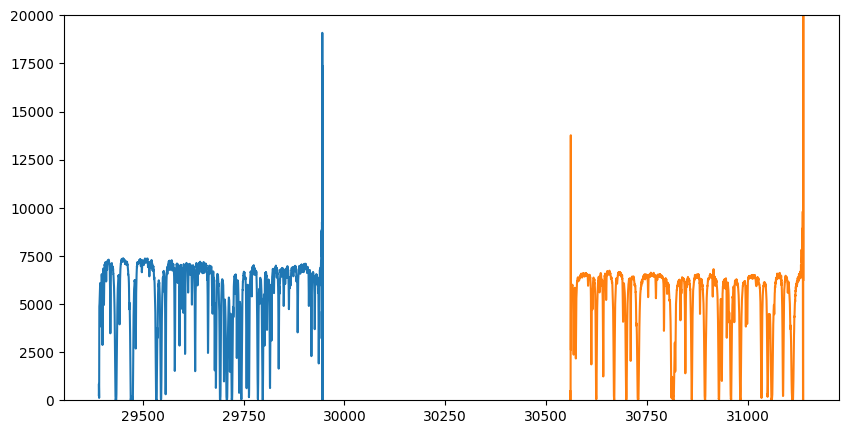

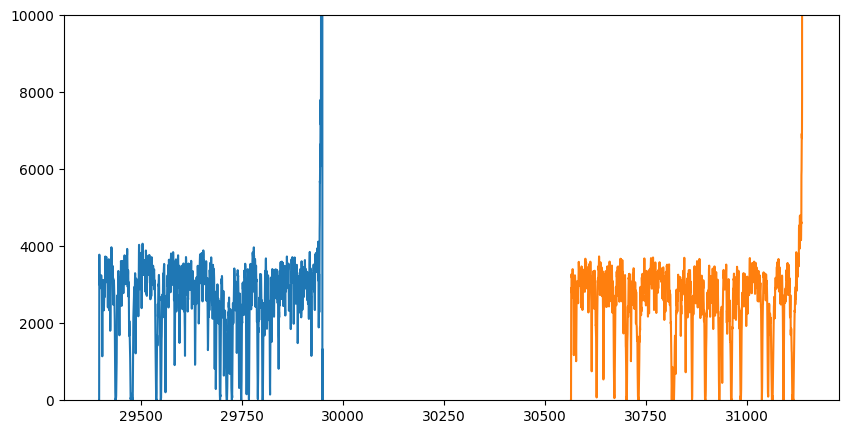

(2034,)


In [8]:
# Plot the telluric standard spectrum
plt.figure(figsize = (10,5))
for ii in range(num_orders): 
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0], flux_std_uc[ii,mask_std_uc[ii,:]>0])
plt.ylim(0,2.0e4)
plt.show()

# Plot the science target spectrum
plt.figure(figsize = (10,5))
for ii in range(num_orders): 
    plt.plot(wave_GL[ii, mask_GL[ii,:]>0], flux_GL[ii,mask_GL[ii,:]>0])
plt.ylim(0,1.0e4)
plt.show()

print(np.shape(wave_std_uc[ii, mask_std_uc[ii,:]>0]))

# Extract the PHOENIX model of the standard from the sensitivity function file

***
When the sensitivity function is computed, PypeIt fits the continuum of the standard data to the reference model spectrum <br />
which in this case is the A0V PHOENIX model. We can then take advantage of this to continuum normalize the telluric standard <br />
spectrum (since the continuum has been set to tbe that of the model) and then use the model to remove any stellar features, <br />
all in one division operation. 
***

In [9]:
wav_modl = hdu_sens[2].data['SENS_FLUXED_STD_WAVE']
flux_modl = hdu_sens[2].data['SENS_STD_MODEL_FLAM']
wav_modl = wav_modl[3:5,:]
flux_modl = flux_modl[3:5,:]

print(np.shape(wav_modl)) # notice that the binning here is different from that of the data

(2, 2048)


# plot only the science data to see if there are any emission lines

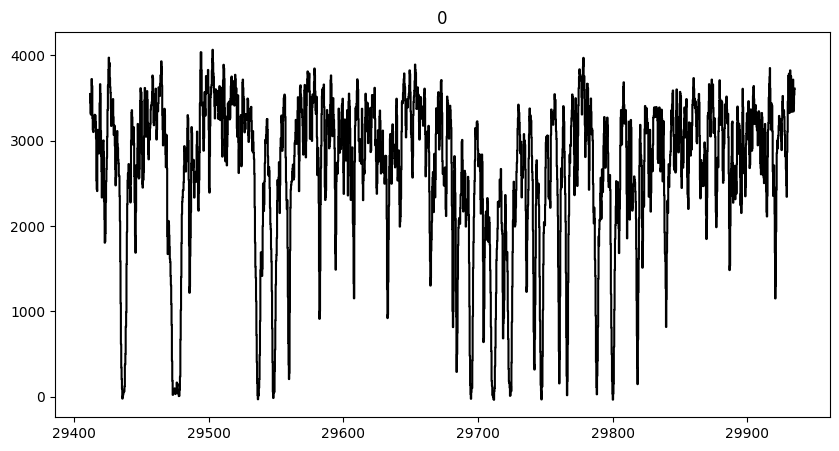

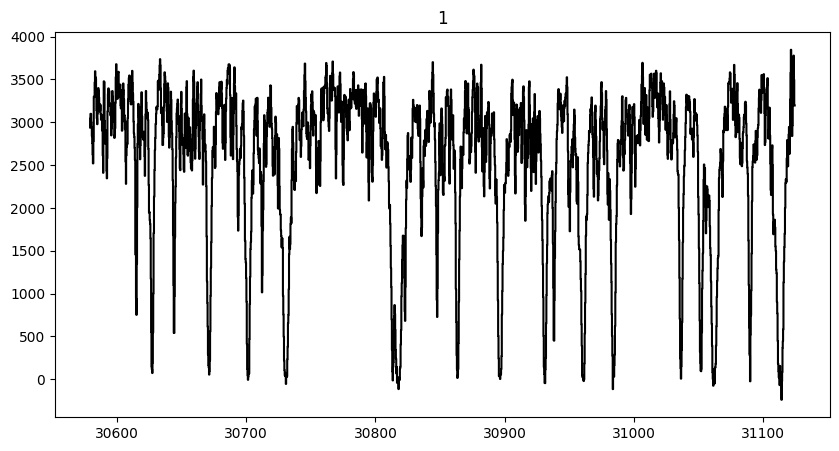

In [10]:
for ii in range(num_orders):
    # extract the unmasked wavelength vector for this order
    wave = wave_GL[ii, mask_GL[ii,:]>0][50:-50]
    # extract the unmasked pixels for this order and divide by the continuum
    dat_flat_GL = flux_GL[ii,mask_GL[ii,:]>0][50:-50]
    plt.figure(figsize = (10,5))
    plt.step(wave, dat_flat_GL, 'k-')
    # print the index number range for the region around the wavelength
    # if ii == 1: print(ii, np.where(np.logical_and(wave > 20325, wave < 20350))[0])
    # if ii == 2: print(ii, np.where(np.logical_and(wave > 21210, wave < 21230))[0])
    # if ii == 3: print(ii, np.where(np.logical_and(wave > 21640, wave < 21700))[0])
    if ii == 4: print(ii, np.where(np.logical_and(wave > 22205, wave < 22240))[0])
    #plt.ylim(0,2.0)
    plt.title(str(ii))
    plt.show()


## Plot the model and the standard, then continuum normalize by dividing the standard by the model to get a telluric spectrum

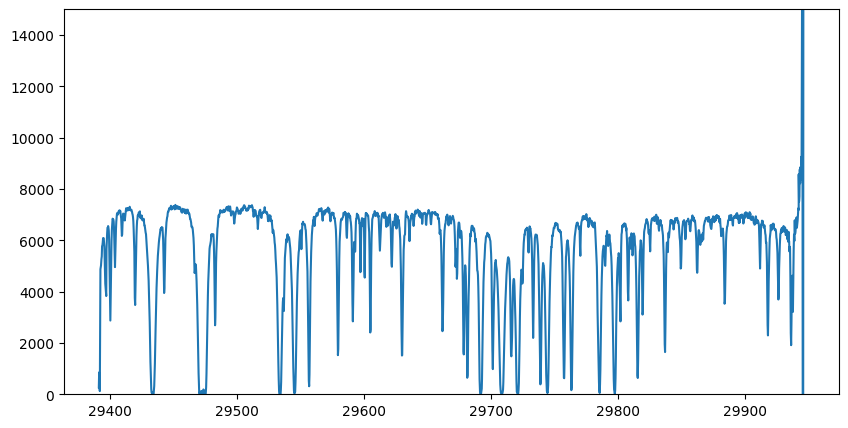

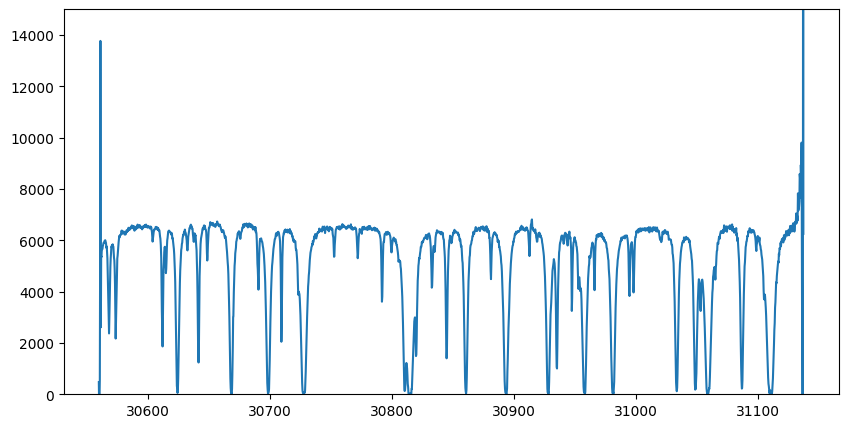

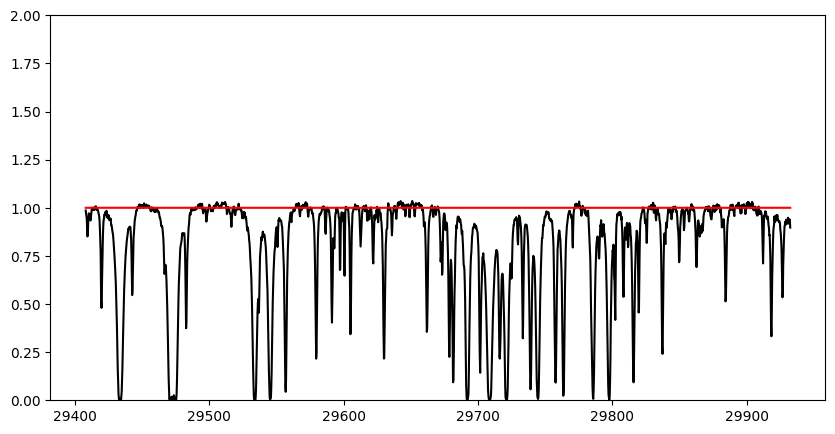

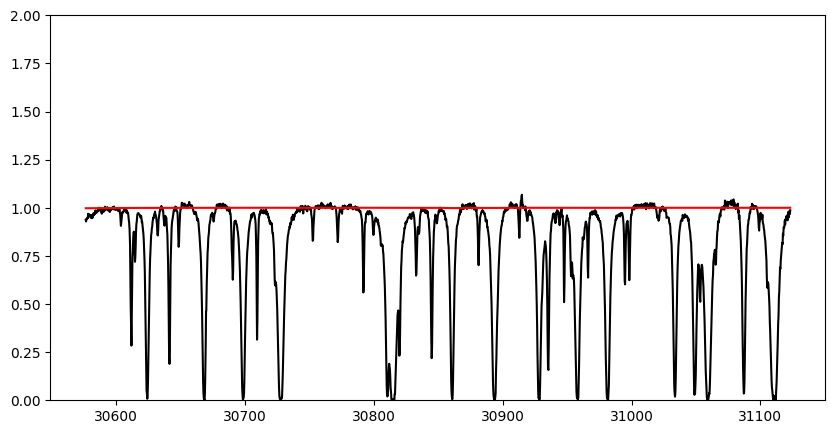

In [11]:
#Plot the standard spectrum to see how it looks
for ii in range(num_orders): 
    plt.figure(figsize = (10,5))
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0], flux_std_uc[ii,mask_std_uc[ii,:]>0])
    plt.ylim(0,1.5e4)
    plt.show()

# define some lists to save the telluric continuum and the flattened model spectrum we'll use
tell_modl = []
tell_cont = []
# RV of the Standard to line up with the phoenix model
rv=0.0
for ii in range(num_orders):
    # broaden the PHOENIX model of the standard and then interpolate it onto the wavelength scale of the observed standard
    #modl_spec = np.interp(wave_std_uc[ii,mask_std_uc[ii,:]>0][50:-50], wav_modl[ii,:], 
    #                   rot_int_cmj(wav_modl[ii,:], flux_modl[ii,:], 150.0))
    modl_spec = scipy.interpolate.interp1d(wav_modl[ii,:], rot_int_cmj(wav_modl[ii,:], flux_modl[ii,:], 150.0), kind = 'quadratic', bounds_error = False, fill_value = 0.0)(wave_std_uc[ii,mask_std_uc[ii,:]>0][50:-50]*(1-rv/2.9979e5))
    # normalize the telluric model
    modl_spec_flat = modl_spec / cont_fit(modl_spec)
    # normalize the standard
    # First compute the continuum for the order
    # if there were any regions with emission lines, they could be masked out by adding the 
    # regions keyword below. A region is defined in pixel space as [blue_pixel, red_pixel], 
    # and the regions would be a list of these. So the argument would be regions = [[blue_pix1, red_pix1], [blue_pix2, red_pix2]]
    #if ii == 1: regions = [[209,331]]
    #elif ii == 2: regions = [[1753,1846]]
    #elif ii == 3: regions = [[965,1241]]
    #elif ii == 4: regions = [[663,820]]
    #else: regions = None
    regions = None
    #print(regions)
    dat_cont = cont_fit(flux_std_uc[ii,mask_std_uc[ii,:]>0][50:-50], regions = regions)
    dat_flat = flux_std_uc[ii,mask_std_uc[ii,:]>0][50:-50]/dat_cont

    #save the continuum used and the telluric spectrum for this order
    tell_cont.append(dat_cont)
    tell_modl.append(dat_flat/modl_spec_flat)
    # plot the two to see how it went
    plt.figure(figsize = (10,5))
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], dat_flat, 'k-')
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], modl_spec_flat, 'r-')
    #plt.plot(wave_std_uc[ii, :], wave_std_uc[ii,:])
    #plt.xlim(9000,15000)
    plt.ylim(0,2.0)
    plt.show()


### For each order, find the shift between the telluric spectrum and the data, apply the shift, and divide the data by the shifted telluric spectrum

If the shift computed by the cross-correlation is bad, which can happen when orders have few tellurics, the line to compute the shifts (wvutils.xcorr_shift is the function)  <br />
should be replaced with a defined pixel shift for each order. Alternatively, if there is no shift, then set shift_cc = 0.0. 

In [12]:
import scipy.optimize


def scale_tell(spec, scale_fact):
    return spec[0]/(1 - scale_fact * (1 - spec[1]))

def calc_best_scale(spec):
    popt, pcov = scipy.optimize.curve_fit(scale_tell, spec, np.ones_like(spec[0]), bounds = [(0.0), (2.0)])
    return popt[0]

### Using a reference order (in this exercise, order 0 is good, echelle order=26) and a reference wavelength range dominated by telluric features (29500 - 29650 here), we will compute the best-fit scaling for telluric features in the spectrum. The procedure will mimic the telluric correction process for all susbsequent orders, so some code and comments are repeated below. 

In [13]:
from pypeit.core.wavecal import wvutils
ii = 0
lam_min = 29570.0
lam_max = 29670.0

# extract the unmasked wavelength vector for this order
wave = wave_GL[ii, mask_GL[ii,:]>0][50:-50]
# compute the continuum for the order
# if there were any regions with emission lines, they could be masked out by adding the 
# regions keyword below. A region is defined in pixel space as [blue_pixel, red_pixel], 
# and the regions would be a list of these. So the argument would be regions = [[blue_pix1, red_pix1], [blue_pix2, red_pix2]]
dat_cont_GL = cont_fit(flux_GL[ii,mask_GL[ii,:]>0][50:-50])
# extract the unmasked pixels for this order and divide by the continuum
dat_flat_GL = flux_GL[ii,mask_GL[ii,:]>0][50:-50]/dat_cont_GL
# interpolate the telluric spectrum onto this wavelength scale
tell_fit_GL = scipy.interpolate.interp1d(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], tell_modl[ii], kind = 'quadratic', bounds_error = False, fill_value = 0.0)(wave_GL[ii, mask_GL[ii,:]>0][50:-50])

# compute the relative shift between the two
shift_cc, corr_cc = wvutils.xcorr_shift(1-dat_flat_GL, 1-tell_fit_GL, debug=False, percent_ceil=50.0, max_lag_frac=0.01) # max_lag_frac restricts the fraction of the order by which to search for a shift

wav_shift = np.median(wave[1:] - wave[0:-1])*shift_cc
print(f'wav_shift = {wav_shift} Angstroms')
# Correct for any small pixel shifts between the telluric and the science target
tell_fit_GL_shift = scipy.interpolate.interp1d(np.arange(len(wave))+shift_cc, tell_fit_GL, kind = 'quadratic', bounds_error = False, fill_value = 0.0)(np.arange(len(wave)))

#now scale the line depths by the necessary factor to match the observation

inds = np.where(np.logical_and(wave > lam_min, wave < lam_max))[0]
tell_scale = calc_best_scale([dat_flat_GL[inds], tell_fit_GL_shift[inds]])
print('tell scale = ', tell_scale)
tell_fit_GL_scale = 1 - tell_scale*(1 - tell_fit_GL_shift)



wav_shift = 2.71489225704852 Angstroms
tell scale =  0.9520198995509482


(1933,) (1933,)
10.010259179470097
wav_shift = 2.71489225704852 Angstroms
tell scale =  0.9520198995509482


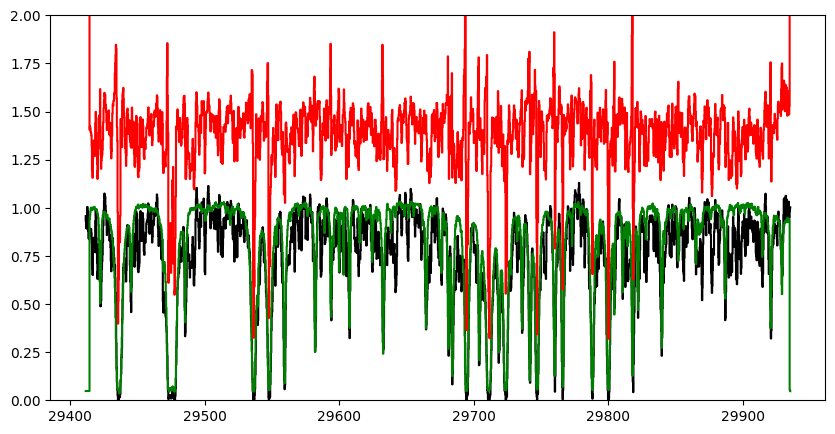

(1935,) (1935,)
9.944330919453872
wav_shift = 2.807012635610924 Angstroms
tell scale =  0.9520198995509482


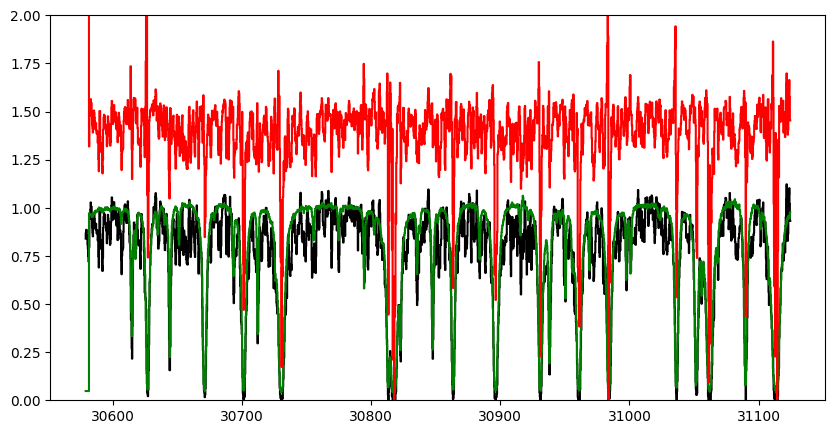

In [14]:


from pypeit.core.wavecal import wvutils
# initialize lists to save the telluric corrected spectral information
flux_GL_notell = []    # telluric corrected science spectrum
wave_GL_notell = []     # wavelength scale for the spectrum
ivar_GL_notell = []     # inverse variance, after flux normalization
flux_tellspec = []      # telluric spectrum used to correct spectrum
cont_GL_notell = []     # continuum used in continuum normalization
for ii in range(num_orders):
    # extract the unmasked wavelength vector for this order
    wave = wave_GL[ii, mask_GL[ii,:]>0][50:-50]
    # compute the continuum for the order
    # if there were any regions with emission lines, they could be masked out by adding the 
    # regions keyword below. A region is defined in pixel space as [blue_pixel, red_pixel], 
    # and the regions would be a list of these. So the argument would be regions = [[blue_pix1, red_pix1], [blue_pix2, red_pix2]]
    dat_cont_GL = cont_fit(flux_GL[ii,mask_GL[ii,:]>0][50:-50])
    # extract the unmasked pixels for this order and divide by the continuum
    dat_flat_GL = flux_GL[ii,mask_GL[ii,:]>0][50:-50]/dat_cont_GL
    # interpolate the telluric spectrum onto this wavelength scale
    tell_fit_GL = scipy.interpolate.interp1d(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], tell_modl[ii], kind = 'quadratic', bounds_error = False, fill_value = 0.0)(wave_GL[ii, mask_GL[ii,:]>0][50:-50])
    print(np.shape(dat_flat_GL), np.shape(tell_fit_GL))
    # compute the relative shift between the two
    shift_cc, corr_cc = wvutils.xcorr_shift(1-dat_flat_GL, 1-tell_fit_GL, debug=False, percent_ceil=50.0, max_lag_frac=0.01) # max_lag_frac restricts the fraction of the order by which to search for a shift
    print(shift_cc)
    wav_shift = np.median(wave[1:] - wave[0:-1])*shift_cc
    print(f'wav_shift = {wav_shift} Angstroms')
    # Correct for any small pixel shifts between the telluric and the science target
    tell_fit_GL_shift = scipy.interpolate.interp1d(np.arange(len(wave))+shift_cc, tell_fit_GL, kind = 'quadratic', bounds_error = False, fill_value = 0.0)(np.arange(len(wave)))

    #now scale the line depths by the necessary factor to match the observation
    #tell_scale = calc_best_scale([dat_flat_GL, tell_fit_GL_shift])
    print('tell scale = ', tell_scale)
    tell_fit_GL_scale = 1 - tell_scale*(1 - tell_fit_GL_shift)

    # save these spectra for later
    flux_GL_notell.append(dat_flat_GL/tell_fit_GL_scale)
    wave_GL_notell.append(wave)
    ivar_GL_notell.append(ivar_GL[ii,mask_GL[ii,:]>0][50:-50]/dat_cont_GL)
    flux_tellspec.append(tell_fit_GL_scale)
    cont_GL_notell.append(np.interp(np.arange(len(wave)), np.arange(len(wave))+shift_cc, dat_cont_GL))

    # plot the results
    plt.figure(figsize = (10,5))
    plt.step(wave, dat_flat_GL, 'k-')
    plt.step(wave, tell_fit_GL_scale, 'g-')
    plt.step(wave, dat_flat_GL/tell_fit_GL_scale+0.5, 'r-')
    plt.ylim(0,2.0)
    plt.show()


1933
1935


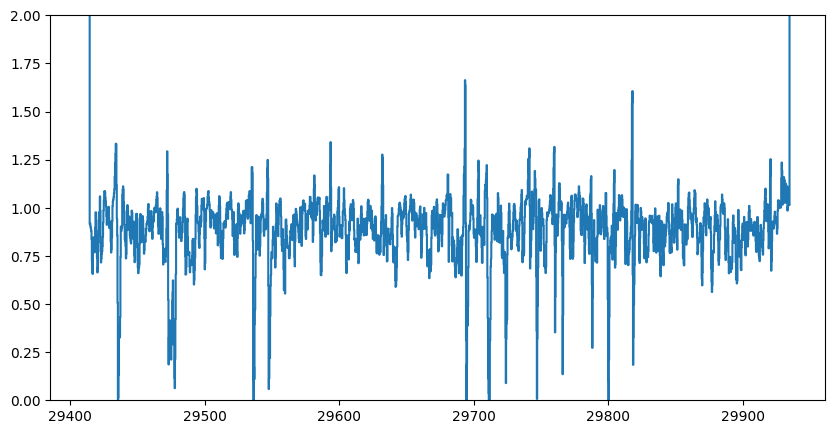

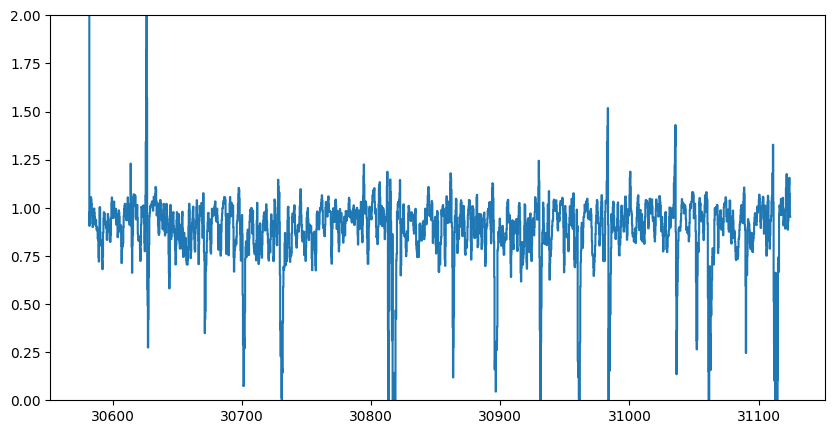

In [15]:
#In order to save the telluric corrected spectra, let's rebin them to an array of consistent size. In this case,
# we'll assume that, since we cut 50 pixels from either end, a full array should have 1950 pixels and the ones 
# that have less than that have some masked values in the middle. 
for ii in range(num_orders): print(len(flux_GL_notell[ii]))
wave_GL_rebin = np.ones((num_orders, 1950))
flux_GL_rebin = np.ones((num_orders, 1950))
cont_GL_rebin = np.ones((num_orders, 1950))
ivar_GL_rebin = np.ones((num_orders, 1950))
tell_spec_rebin = np.ones((num_orders,1950))

for ii in range(num_orders):
    # compute linear wavelength for the order, assuming 1950 pixels in the order
    wave_GL_rebin[ii,:] = np.linspace(np.min(wave_GL_notell[ii]), np.max(wave_GL_notell[ii]), 1950)
    # interpolate the other vectors onto this wavelength grid
    flux_GL_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], flux_GL_notell[ii])
    ivar_GL_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], ivar_GL_notell[ii])
    tell_spec_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], flux_tellspec[ii])
    cont_GL_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], cont_GL_notell[ii])
    plt.figure(figsize = (10,5))
    plt.step(wave_GL_rebin[ii,:], flux_GL_rebin[ii,:])
    plt.ylim(0,2)
    plt.show()

In [16]:
# save the continuum fit that was used to normalize the telluric spectrum, but in the same type of 
# padded array that the telluric spectrum is saved as
tell_cont_array = np.zeros(np.shape(flux_std_uc))
for ii in range(num_orders):
    padding = np.zeros(50)
    tell_cont_array[ii, mask_std_uc[ii,:]>0] = np.append(np.append(padding, tell_cont[ii]), padding)
    

In [17]:
from astropy.table import Table
# make astropy tables to save the different pieces that went into this dataset
# NOTE: Headers still not quite figured out, so they won't have all the information we want to retain in the future
telluric_table=Table([['telluric'], [header_std_uc], [wave_std_uc],
                  [flux_std_uc], [ivar_std_uc],
                  [mask_std_uc], [tell_cont_array]],
                  names=('obj type', 'header', 'wave', 'flux', 'ivar','mask','cont_fit'))

science_og_table=Table([['science'], [header_GL], [wave_GL],
                  [flux_GL], [ivar_GL],
                  [mask_GL]],
                  names=('obj type','header' , 'wave', 'flux', 'ivar','mask'))

science_corr_table=Table([['science corrected'], [wave_GL_rebin],
                  [flux_GL_rebin], [ivar_GL_rebin], [tell_spec_rebin], [cont_GL_rebin]],
                  names=('obj type','wave', 'flux', 'ivar', 'tell_spec', 'cont_fit'))


hdulist = fits.HDUList()
hdulist.append(fits.BinTableHDU(telluric_table.as_array()))  # hdu = 1
hdulist.append(fits.BinTableHDU(science_og_table.as_array()))  # hdu = 2
hdulist.append(fits.BinTableHDU(science_corr_table.as_array()))  # hdu = 3
hdulist.writeto('GL745A_Lband2_tellcorr_opt.fits', overwrite=True)


In [11]:
import numpy as np

# Load the full telluric standard
data = np.load('/Users/ava/Desktop/Stellar_Spectra/Lband2/telluric_standardL2.npz')
wave = data['wave']
flux = data['flux']
mask = data['mask']

print("Original shape:", wave.shape)  # Should be (6, N_pixels) or similar

# Keep only the last 3 orders (e.g., orders 3, 4, 5)
wave_trimmed = wave[-2:]
flux_trimmed = flux[-2:]
mask_trimmed = mask[-2:]

print("Trimmed shape:", wave_trimmed.shape)  # Should be (3, N_pixels)

# Save the trimmed version to a new file
np.savez('/Users/ava/Desktop/Stellar_Spectra/Lband2/telluric_standardL2_trimmed.npz',
         wave=wave_trimmed, flux=flux_trimmed, mask=mask_trimmed)

Original shape: (5, 18236)
Trimmed shape: (2, 18236)


 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/HD164259_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/HD203473_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/HD199381_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/GL514_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/GL745A_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/GL628_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/GL555_Lband2_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/l2_fits/GJ876_Lband2_tellcorr_opt.fits
Saved: /Users/ava/Desktop/Spectral Website/plots/L2_Plots/plots_stacked/l2_order0.png
Saved: /Users/ava/Desktop/Spectral Website/plots/L2_Plots/plots_stacked/l2_order1.png


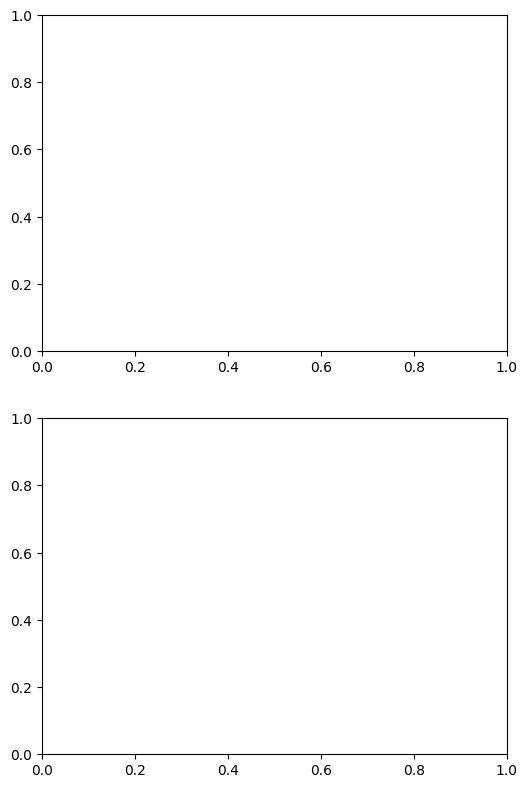

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm

# --- File paths and corresponding Teff values ---   
science_data = [
    ('/users/ava/desktop/Spectral Website/data/l2_fits/HD164259_Lband2_tellcorr_opt.fits', 6454),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/HD203473_Lband2_tellcorr_opt.fits', 5781),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/HD199381_Lband2_tellcorr_opt.fits', 5013),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL514_Lband2_tellcorr_opt.fits', 3727),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL745A_Lband2_tellcorr_opt.fits', 3500),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL628_Lband2_tellcorr_opt.fits', 3272),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GJ876_Lband2_tellcorr_opt.fits', 3129),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL555_Lband2_tellcorr_opt.fits', 3211)
]

# Sort by descending Teff (hottest first, coolest last)
science_data.sort(key=lambda x: -x[1])
science_files, teff_values = zip(*science_data)

# --- Load telluric standard ---
tell = np.load('/Users/ava/Desktop/Spectral Website/data/l2_fits/telluric_standardL2_trimmed.npz')
wave_tell, flux_tell, mask_tell = tell['wave'], tell['flux'], tell['mask']
n_orders = wave_tell.shape[0]

# --- Load science spectra ---
loaded = []
for f in science_files:
    try:
        hdu = fits.open(f)
        d = hdu[2].data[0]
        loaded.append((f, d['wave'], d['flux'], d['mask']))
        print(f" Loaded {f}")
    except Exception as e:
        print(f" Failed to load {f}: {e}")

# --- Plot setup: 1 tall column ---
fig, axes = plt.subplots(n_orders, 1, figsize=(6, 4.8 * n_orders), sharex=False)

offset = 1.2  # spacing to avoid overlap
y_labels = [f.split('/')[-1].split('_')[0] for f, _, _, _ in loaded]
colors = plt.get_cmap('tab10').colors  # darker colors

# --- Plot each spectral order ---
for i_order in range(n_orders):
    fig, ax = plt.subplots(figsize=(6, 5))  # Create one figure per order
    all_y = []

    for j, (fpath, wave, flux, mask) in enumerate(loaded):
        try:
            good = mask[i_order] > 0
            w = wave[i_order][good][50:-50] / 1e4
            f = flux[i_order][good][50:-50]
            norm = (f - np.nanmin(f)) / (np.nanmax(f) - np.nanmin(f))
            y = norm + (len(loaded) - j) * offset

            color = colors[j % len(colors)]
            ax.plot(w, y, lw=1, color=color)
            all_y.extend(y)

            if i_order in [1, 4]:
                ax.text(w[0], np.max(y), f"{y_labels[j]} ({teff_values[j]}K)",
                        fontsize=7, verticalalignment='bottom', color='black', ha='left')
        except Exception as e:
            print(f" Plot failed for {fpath} order {i_order}: {e}")

    # Telluric standard
    try:
        good_tell = mask_tell[i_order] > 0
        w_tell = wave_tell[i_order][good_tell][50:-50] / 1e4
        f_tell = flux_tell[i_order][good_tell][50:-50]
        norm_tell = (f_tell - np.nanmin(f_tell)) / (np.nanmax(f_tell) - np.nanmin(f_tell))
        y_tell = norm_tell - 0.2 * offset

        ax.plot(w_tell, y_tell, lw=1, color='black')
        if i_order in [1, 4]:
            ax.text(w_tell[0], np.max(y_tell) + 0.05, "Telluric Standard",
                    fontsize=7, verticalalignment='bottom', color='black', ha='left')
        all_y.extend(y_tell)
    except Exception as e:
        print(f" Failed to plot telluric standard for order {i_order}: {e}")

    if all_y:
        ymin = min(all_y) - 0.2
        ymax = max(all_y) + 0.4
        ax.set_ylim(ymin, ymax)

    ax.set_ylabel(r'$F_\lambda$ + constant', fontsize=9)
    ax.tick_params(axis='both', direction='out', bottom=True, top=False, left=True, right=False)
    ax.tick_params(labelrotation=0, labelsize=8)
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlabel(r'$\lambda\,(\mu m)$', fontsize=9)
    ax.set_title(f"L-band2 Spectral Order {i_order + 1}", fontsize=10, weight='bold')

    # Save each figure
    outname = f"/Users/ava/Desktop/Spectral Website/plots/L2_Plots/plots_stacked/l2_order{i_order}.png"
    plt.tight_layout()
    plt.savefig(outname, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {outname}")

 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/HD164259_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/HD203473_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/HD199381_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/GL514_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/GL745A_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/GL628_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/GL555_Kband4_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/k4_fits/GJ876_Kband4_tellcorr_opt.fits
Saved: /Users/ava/Desktop/Spectral Website/plots/K4_order0.png
Saved: /Users/ava/Desktop/Spectral Website/plots/K4_order1.png
Saved: /Users/ava/Desktop/Spectral Website/plots/K4_order2.png
Saved: /Users/ava/Desktop/Spectral Website/plots/K4_order3.png


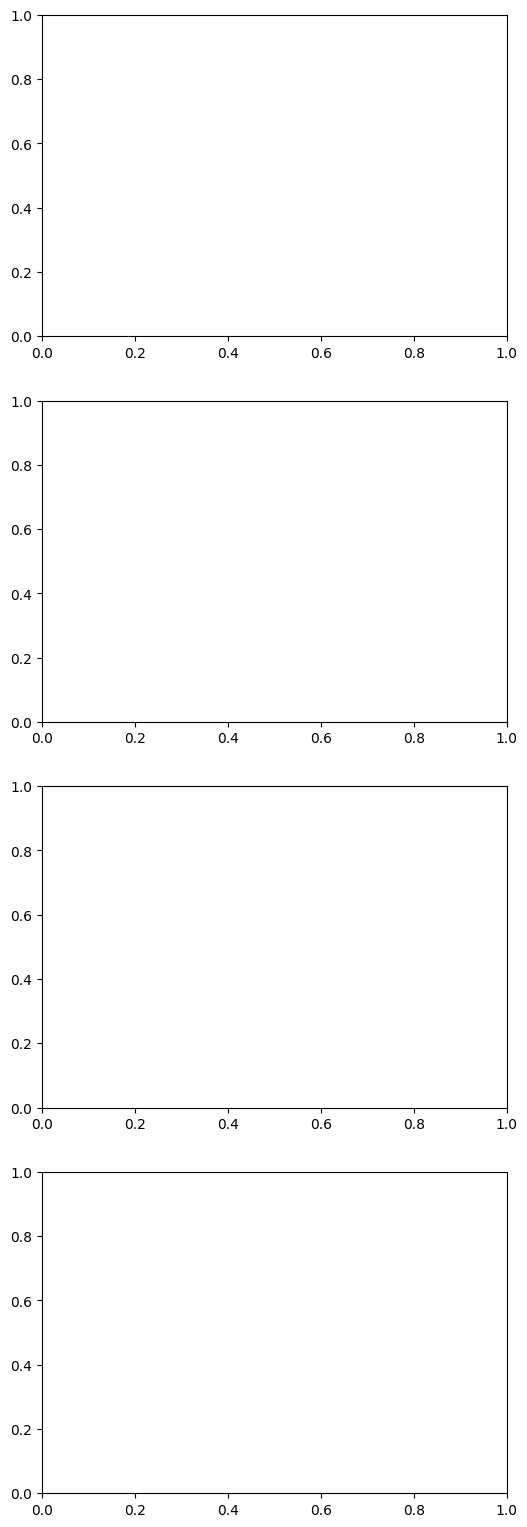

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm

# --- File paths and corresponding Teff values ---   
science_data = [
    ('/users/ava/desktop/Spectral Website/data/k4_fits/HD164259_Kband4_tellcorr_opt.fits', 6454),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/HD203473_Kband4_tellcorr_opt.fits', 5781),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/HD199381_Kband4_tellcorr_opt.fits', 5013),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/GL514_Kband4_tellcorr_opt.fits', 3727),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/GL745A_Kband4_tellcorr_opt.fits', 3500),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/GL628_Kband4_tellcorr_opt.fits', 3272),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/GJ876_Kband4_tellcorr_opt.fits', 3129),
    ('/users/ava/desktop/Spectral Website/data/k4_fits/GL555_Kband4_tellcorr_opt.fits', 3211)
]

# Sort by descending Teff (hottest first, coolest last)
science_data.sort(key=lambda x: -x[1])
science_files, teff_values = zip(*science_data)

# --- Load telluric standard ---
tell = np.load('/Users/ava/Desktop/Spectral Website/data/k4_fits/telluric_standardk4.npz')
wave_tell, flux_tell, mask_tell = tell['wave'], tell['flux'], tell['mask']
n_orders = wave_tell.shape[0]

# --- Load science spectra ---
loaded = []
for f in science_files:
    try:
        hdu = fits.open(f)
        d = hdu[2].data[0]
        loaded.append((f, d['wave'], d['flux'], d['mask']))
        print(f" Loaded {f}")
    except Exception as e:
        print(f" Failed to load {f}: {e}")

# --- Plot setup: 1 tall column ---
fig, axes = plt.subplots(n_orders, 1, figsize=(6, 4.8 * n_orders), sharex=False)

offset = 1.2  # spacing to avoid overlap
y_labels = [f.split('/')[-1].split('_')[0] for f, _, _, _ in loaded]
colors = plt.get_cmap('tab10').colors  # darker colors

# --- Plot each spectral order ---
for i_order in range(n_orders):
    fig, ax = plt.subplots(figsize=(6, 5))  # Create one figure per order
    all_y = []

    for j, (fpath, wave, flux, mask) in enumerate(loaded):
        try:
            good = mask[i_order] > 0
            w = wave[i_order][good][50:-50] / 1e4
            f = flux[i_order][good][50:-50]
            norm = (f - np.nanmin(f)) / (np.nanmax(f) - np.nanmin(f))
            y = norm + (len(loaded) - j) * offset

            color = colors[j % len(colors)]
            ax.plot(w, y, lw=1, color=color)
            all_y.extend(y)

            if i_order in [1, 4]:
                ax.text(w[0], np.max(y) - 0.2, f"{y_labels[j]} ({teff_values[j]}K)",
                        fontsize=7, verticalalignment='bottom', color='black', ha='left')
        except Exception as e:
            print(f" Plot failed for {fpath} order {i_order}: {e}")

    # Telluric standard
    try:
        good_tell = mask_tell[i_order] > 0
        w_tell = wave_tell[i_order][good_tell][50:-50] / 1e4
        f_tell = flux_tell[i_order][good_tell][50:-50]
        norm_tell = (f_tell - np.nanmin(f_tell)) / (np.nanmax(f_tell) - np.nanmin(f_tell))
        y_tell = norm_tell - 0.2 * offset

        ax.plot(w_tell, y_tell, lw=1, color='black')
        if i_order in [1, 4]:
            ax.text(w_tell[0], np.max(y_tell) + 0.05, "Telluric Standard",
                    fontsize=7, verticalalignment='bottom', color='black', ha='left')
        all_y.extend(y_tell)
    except Exception as e:
        print(f" Failed to plot telluric standard for order {i_order}: {e}")

    if all_y:
        ymin = min(all_y) - 0.2
        ymax = max(all_y) + 0.4
        ax.set_ylim(ymin, ymax)

    ax.set_ylabel(r'$F_\lambda$ + constant', fontsize=9)
    ax.tick_params(axis='both', direction='out', bottom=True, top=False, left=True, right=False)
    ax.tick_params(labelrotation=0, labelsize=8)
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlabel(r'$\lambda\,(\mu m)$', fontsize=9)
    ax.set_title(f"K-band2 Spectral Order {i_order}", fontsize=10, weight='bold')

    # Save each figure
    outname = f"/Users/ava/Desktop/Spectral Website/plots/K4_order{i_order}.png"
    plt.tight_layout()
    plt.savefig(outname, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {outname}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

# --- Science files and Teff ---
science_data = [
    ('/Users/ava/Desktop/Spectral Website/data/l2_fits/HD164259_lband2_tellcorr_opt.fits', 6454),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/HD203473_lband2_tellcorr_opt.fits', 5781),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/HD199381_lband2_tellcorr_opt.fits', 5013),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL514_lband2_tellcorr_opt.fits', 3727),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL745A_lband2_tellcorr_opt.fits', 3500),
    ('/Users/ava/Desktop/Spectral Website/data/l2_fits/GL628_lband2_tellcorr_opt.fits', 3272),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GJ876_lband2_tellcorr_opt.fits', 3129),
    ('/users/ava/desktop/Spectral Website/data/l2_fits/GL555_lband2_tellcorr_opt.fits', 3211),
]

# Sort by descending Teff
science_data.sort(key=lambda x: -x[1])

# --- Load telluric standard ---
tell = np.load('/Users/ava/Desktop/Spectral Website/data/l2_fits/telluric_standardL2_trimmed.npz')
wave_tell, flux_tell, mask_tell = tell['wave'], tell['flux'], tell['mask']
n_orders = wave_tell.shape[0]

# --- Define telluric regions to shade (microns) ---
telluric_regions = [
    (1.35, 1.42),
    (1.80, 1.95),
    (2.50, 2.90),
]

# --- Output directory ---
output_dir = "plots_bw"
os.makedirs(output_dir, exist_ok=True)

# --- Plot each star: one plot per spectral order ---
for filepath, teff in science_data:
    try:
        hdu = fits.open(filepath)
        d = hdu[2].data[0]
        wave = d['wave']
        flux = d['flux']
        mask = d['mask']
        starname = os.path.basename(filepath).split('_')[0]

        for i_order in range(n_orders):
            fig, ax = plt.subplots(figsize=(6, 4))
            try:
                good = mask[i_order] > 0
                w = wave[i_order][good][50:-50] / 1e4  # to microns
                f = flux[i_order][good][50:-50]
                norm = (f - np.nanmin(f)) / (np.nanmax(f) - np.nanmin(f))

                ax.plot(w, norm, color='black', lw=0.7)

                # Shade telluric regions
                for start, end in telluric_regions:
                    ax.axvspan(start, end, color='gray', alpha=0.3)

                # Axis and style
                ax.set_title(f"{starname}", fontsize=11)
                ax.set_xlabel(r"Wavelength ($\mu$m)", fontsize=10)
                ax.set_ylabel(r"$f_\lambda$ ($10^{-10}\,\mathrm{W\,m^{-2}\,\mu m^{-1}}$)", fontsize=10)
                ax.tick_params(labelsize=9, direction='out')
                ax.set_ylim(-0.1, 1.1)
                ax.set_xlim(w[0], w[-1])
                ax.grid(False)
                plt.tight_layout()

                # Save
                plotname = os.path.join(output_dir, f"{starname}_order{i_order}.png")
                plt.savefig(plotname, dpi=300, bbox_inches='tight', facecolor='white')
                plt.close()
                print(f"Saved: {plotname}")

            except Exception as e:
                print(f"Plot error for {starname}, order {i_order}: {e}")
    except Exception as e:
        print(f"Failed to load {filepath}: {e}")

# --- Plot telluric standard by itself ---
for i_order in range(n_orders):
    fig, ax = plt.subplots(figsize=(6, 4))
    try:
        good = mask_tell[i_order] > 0
        w = wave_tell[i_order][good][50:-50] / 1e4
        f = flux_tell[i_order][good][50:-50]
        norm = (f - np.nanmin(f)) / (np.nanmax(f) - np.nanmin(f))
        ax.plot(w, norm, color='black', lw=0.7)

        for start, end in telluric_regions:
            ax.axvspan(start, end, color='gray', alpha=0.3)

        ax.set_title("Telluric Standard", fontsize=11)
        ax.set_xlabel(r"Wavelength ($\mu$m)", fontsize=10)
        ax.set_ylabel(r"$f_\lambda$ ($10^{-10}\,\mathrm{W\,m^{-2}\,\mu m^{-1}}$)", fontsize=10)
        ax.tick_params(labelsize=9, direction='out')
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlim(w[0], w[-1])
        ax.grid(False)
        plt.tight_layout()

        plotname = os.path.join(output_dir, f"TelluricStandard_order{i_order}.png")
        plt.savefig(plotname, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"Saved: {plotname}")

    except Exception as e:
        print(f"Telluric plot error (order {i_order}): {e}")

Saved: plots_bw/HD164259_order0.png
Saved: plots_bw/HD164259_order1.png
Saved: plots_bw/HD203473_order0.png
Saved: plots_bw/HD203473_order1.png
Saved: plots_bw/HD199381_order0.png
Saved: plots_bw/HD199381_order1.png
Saved: plots_bw/GL514_order0.png
Saved: plots_bw/GL514_order1.png
Saved: plots_bw/GL745A_order0.png
Saved: plots_bw/GL745A_order1.png
Saved: plots_bw/GL628_order0.png
Saved: plots_bw/GL628_order1.png
Saved: plots_bw/GL555_order0.png
Saved: plots_bw/GL555_order1.png
Saved: plots_bw/GJ876_order0.png
Saved: plots_bw/GJ876_order1.png
Saved: plots_bw/TelluricStandard_order0.png
Saved: plots_bw/TelluricStandard_order1.png
